In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras import applications 
from keras.models import Model
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.densenet import DenseNet121
from sklearn.metrics import confusion_matrix
from glob import glob
from builtins import range, input
from keras.layers import Input, Lambda, Dense, Flatten
import os

In [ ]:
path = '/content/drive/MyDrive/EyePACS/Messidor-2+EyePac_Balanced'
data_dir_list = os.listdir(path)
data_dir_list

['0', '4', '1', '3', '2']

In [ ]:
img_rows=224
img_cols=224
num_channel=3
img_data_list=[]
classes_names_list=[]
target_column=[]

In [ ]:
import cv2
for dataset in data_dir_list:
    classes_names_list.append(dataset)
    print("Getting image from {} folder".format(dataset))
    img_list= os.listdir(path +"/"+ dataset)
    for img in img_list:
        input_img = cv2.imread(path +"/"+dataset+"/"+img)
        input_img_resize=cv2.resize(input_img,(img_rows,img_cols))
        img_data_list.append(input_img_resize)
        target_column.append(dataset)

Getting image from 0 folder
Getting image from 4 folder
Getting image from 1 folder
Getting image from 3 folder
Getting image from 2 folder


In [ ]:
num_classes = len(classes_names_list)
print("num_classes",num_classes)
img_data = np.array(img_data_list) # convert images in numpy array 
img_data = img_data.astype('float32')
img_data /= 255
print("Shape of image data",img_data.shape)
num_of_samples = img_data.shape[0]
input_shape = img_data[0].shape 
print("number of samples",num_of_samples)
print("target column before encoding",target_column)

num_classes 5
Shape of image data (1800, 224, 224, 3)
number of samples 1800
target column before encoding ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0

In [ ]:
from sklearn.preprocessing import LabelEncoder
Labelencoder = LabelEncoder()
target_column = Labelencoder.fit_transform(target_column)
np.unique(target_column)

array([0, 1, 2, 3, 4])

In [ ]:
target_column

array([0, 0, 0, ..., 2, 2, 2])

In [ ]:
from keras.utils.np_utils import to_categorical
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
target_column_hotcoded = to_categorical(target_column,num_classes)
X,Y = shuffle(img_data,target_column_hotcoded,random_state=2)
X_train,X_temp,y_train,y_temp = train_test_split(X,Y,test_size=0.3,random_state=2)
X_test,X_val,y_test,y_val = train_test_split(X_temp,y_temp,test_size=0.3,random_state=2)

In [ ]:
densenet = DenseNet121(input_shape=[224,224,3], weights='imagenet', include_top=False)
# For not training the VGG weights
for layer in densenet.layers:
  layer.trainable = False
x = Flatten()(densenet.output)
prediction = Dense(5, activation='softmax')(x)

model = Model(inputs=densenet.input, outputs=prediction)

29097984/29084464 [==============================] - 0s 0us/step


In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
______________________________________________________________________________________________

In [ ]:
model.compile(loss='categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])

In [ ]:
from keras.applications.vgg16 import preprocess_input
datagen = ImageDataGenerator(validation_split=0.2, preprocessing_function = preprocess_input)
train_generator = datagen.flow_from_directory(
path,
subset='training',
target_size=[224,224],
classes = ['0','1','2','3','4'],
class_mode = 'categorical')
valid_generator = datagen.flow_from_directory(
path, 
subset='validation',
target_size=[224,224],
classes = ['0','1','2','3','4'],
class_mode = 'categorical')

Found 1440 images belonging to 5 classes.
Found 360 images belonging to 5 classes.


In [ ]:
history = model.fit_generator(
  train_generator,
  validation_data=valid_generator,
  epochs=50,
  steps_per_epoch= 1,
  verbose = 1)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
1/1 [==============================] - 95s 95s/step - loss: 5.5202 - accuracy: 0.1875 - val_loss: 82.6808 - val_accuracy: 0.2111
Epoch 2/50
1/1 [==============================] - 51s 51s/step - loss: 83.9620 - accuracy: 0.2188 - val_loss: 127.6733 - val_accuracy: 0.2000
Epoch 3/50
1/1 [==============================] - 50s 50s/step - loss: 144.8646 - accuracy: 0.1250 - val_loss: 67.7171 - val_accuracy: 0.2056
Epoch 4/50
1/1 [==============================] - 49s 49s/step - loss: 85.6033 - accuracy: 0.1562 - val_loss: 23.5711 - val_accuracy: 0.1972
Epoch 5/50
1/1 [==============================] - 50s 50s/step - loss: 21.2231 - accuracy: 0.3438 - val_loss: 43.2802 - val_accuracy: 0.3861
Epoch 6/50
1/1 [==============================] - 50s 50s/step - loss: 50.0208 - accuracy: 0.3125 - val_loss: 60.0055 - val_accuracy: 0.3111
Epoch 7/50
1/1 [==============================] - 50s 50s/step - loss: 70.2072 - accuracy: 0.1562 - val_loss: 46.7708 - val_accuracy: 0.3139
Epoch 8/50
1

In [ ]:
batch_size = 32
y_pred = model.predict(X_test, batch_size=batch_size)

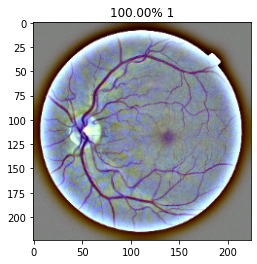

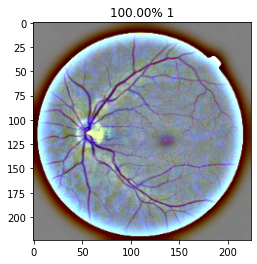

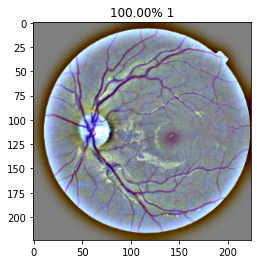

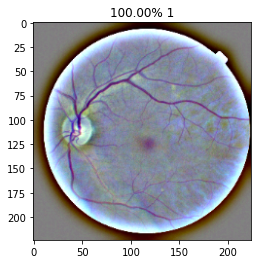

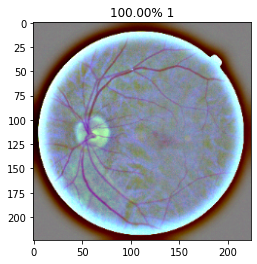

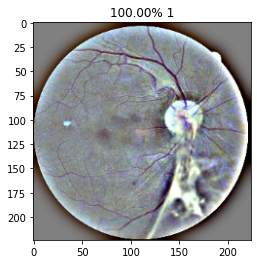

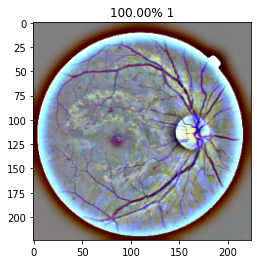

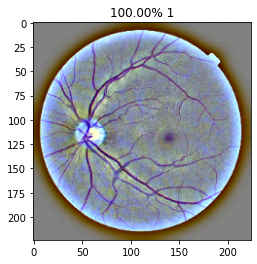

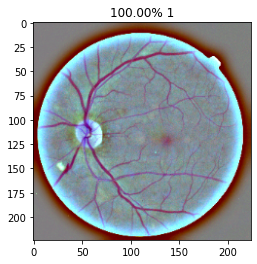

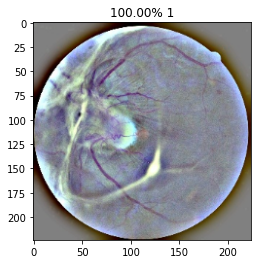

In [ ]:
prediction=y_pred[0:10]
for index, probability in enumerate(prediction):
  if probability[1] > 0.5:
        plt.title('%.2f' % (probability[1]*100) + '% 0')
  else:
        plt.title('%.2f' % ((1-probability[1])*100) + '% 1')
  plt.imshow(X_test[index])
  plt.show()

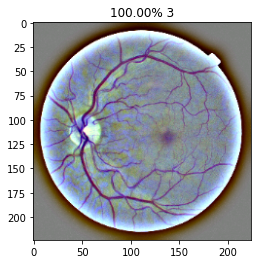

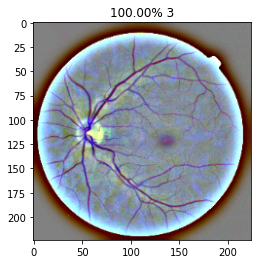

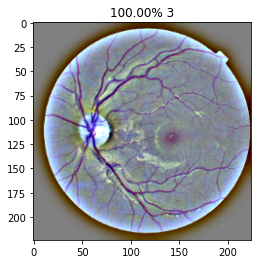

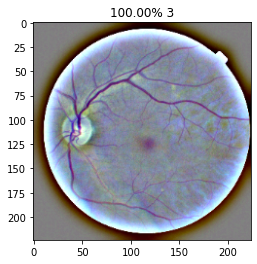

In [ ]:
prediction=y_pred[16:20]
for index, probability in enumerate(prediction):
  if probability[1] > 0.5:
        plt.title('%.2f' % (probability[1]*100) + '% 2')
  else:
        plt.title('%.2f' % ((1-probability[1])*100) + '% 3')
  plt.imshow(X_test[index])
  plt.show()

In [ ]:
y_pred_bin = np.argmax(y_pred, axis=1)
y_test_bin = np.argmax(y_test, axis=1)

In [ ]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(normalize):
  classes = ['0','1','2','3','4']
  tick_marks = [0.5,1.5,2.5,3.5,4.5]
  cn = confusion_matrix(y_test_bin, y_pred_bin,normalize=normalize)
  sns.heatmap(cn,cmap='plasma',annot=True)
  plt.xticks(tick_marks, classes)
  plt.yticks(tick_marks, classes)
  plt.title('Confusion Matrix')
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

Confusion Matrix without Normalization


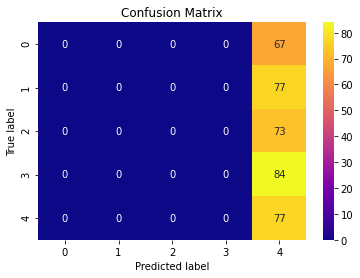

In [ ]:
import seaborn as sns
print('Confusion Matrix without Normalization')
plot_confusion_matrix(normalize=None)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test_bin, y_pred_bin))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        67
           1       0.00      0.00      0.00        77
           2       0.00      0.00      0.00        73
           3       0.00      0.00      0.00        84
           4       0.20      1.00      0.34        77

    accuracy                           0.20       378
   macro avg       0.04      0.20      0.07       378
weighted avg       0.04      0.20      0.07       378



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
